# Facial Landmark Detection - Demonstration
Introduction to Deep Learning - Murphy, Aziha, Alaa  

_This demo is meant to be run in Google Colab! You can find it [here](https://colab.research.google.com/github/StrangeGirlMurph/Facial-Landmark-Detection/blob/master/demo.ipynb)_

# Preparation

To work with the preprocessed data and pretrained models we will simply clone the GitHub repo and work from there.

In [1]:
!git clone https://github.com/StrangeGirlMurph/Facial-Landmark-Detection.git
%cd /content/Facial-Landmark-Detection/src
!git lfs pull

Cloning into 'Facial-Landmark-Detection'...
remote: Enumerating objects: 1657, done.
remote: Counting objects: 100% (374/374), done.
remote: Compressing objects: 100% (347/347), done.
remote: Total 1657 (delta 43), reused 341 (delta 27), pack-reused 1283
Receiving objects: 100% (1657/1657), 110.84 MiB | 31.17 MiB/s, done.
Resolving deltas: 100% (296/296), done.
/content/Facial-Landmark-Detection/src
Git LFS: (22 of 22 files) 792.96 MB / 792.96 MB


We also need to import some basic libraries.

In [2]:
import numpy as np

# Loading the data

In [3]:
from util.dataUtil import loadData, loadAugmentedData

X_train, y_train = loadData(includeAugmented=False, includeTestData=False)
X_augmented, y_augmented = loadAugmentedData()

# The data should include the augmented data.
X = np.concatenate((X_train, X_augmented))
y = np.concatenate((y_train, y_augmented))


> Loading the data...


The dataset with the augmented data in total consists of 17749 96x96 images and their corresponding labels (15 landmarks with x,y-coordinates each):

In [4]:
X.shape, y.shape

((17749, 96, 96, 1), (17749, 30))

Keep in mind though that this data is already preprocessed and the labels include filling values (-1). The training data now consists of about 60% of augmented data.

# Visualizing the data

Let's look at some images and their landmarks.

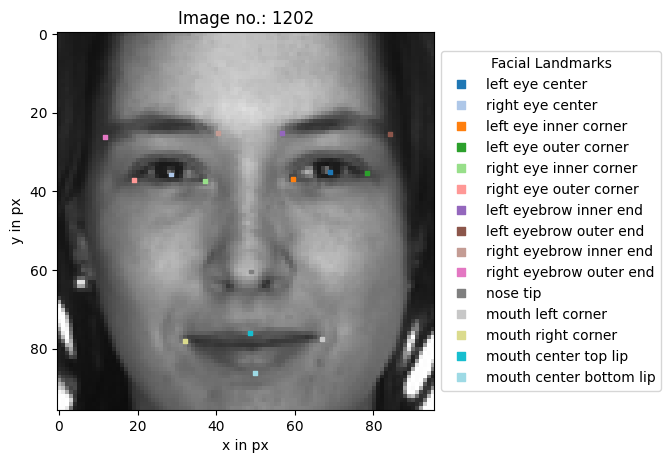

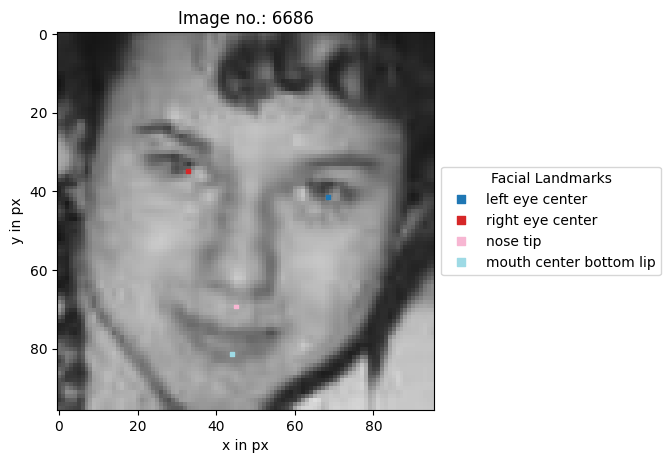

In [5]:
from util.plottingUtil import plotImageWithLabels
for i in [1202, 6686]:
  plotImageWithLabels(X[i], y[i], f"Image no.: {i}")

# Loading the trained model

In [6]:
from util.modelUtil import loadModel
modelV1 = loadModel("../models/modelV1") # for comparison
model = loadModel("../models/modelV4")


> Loading the model...

> Loading the model...


In [7]:
print("Loss:", model.loss.__name__)
print("Metrics:", model.metrics_names)
model.summary(line_length=100)

Loss: masked_mean_squared_error
Metrics: ['loss', 'masked_mean_absolute_error', 'masked_accuracy']
Model: "sequential"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 conv2d (Conv2D)                             (None, 96, 96, 32)                      288            
                                                                                                    
 leaky_re_lu (LeakyReLU)                     (None, 96, 96, 32)                      0              
                                                                                                    
 batch_normalization (BatchNormalization)    (None, 96, 96, 32)                      128            
                                                                                                    
 conv2d_1 (Conv2D)                           (None, 96, 96, 32)          

# Testing the model

## On the dataset

>>> Model V1 <<<

> Testing the model...


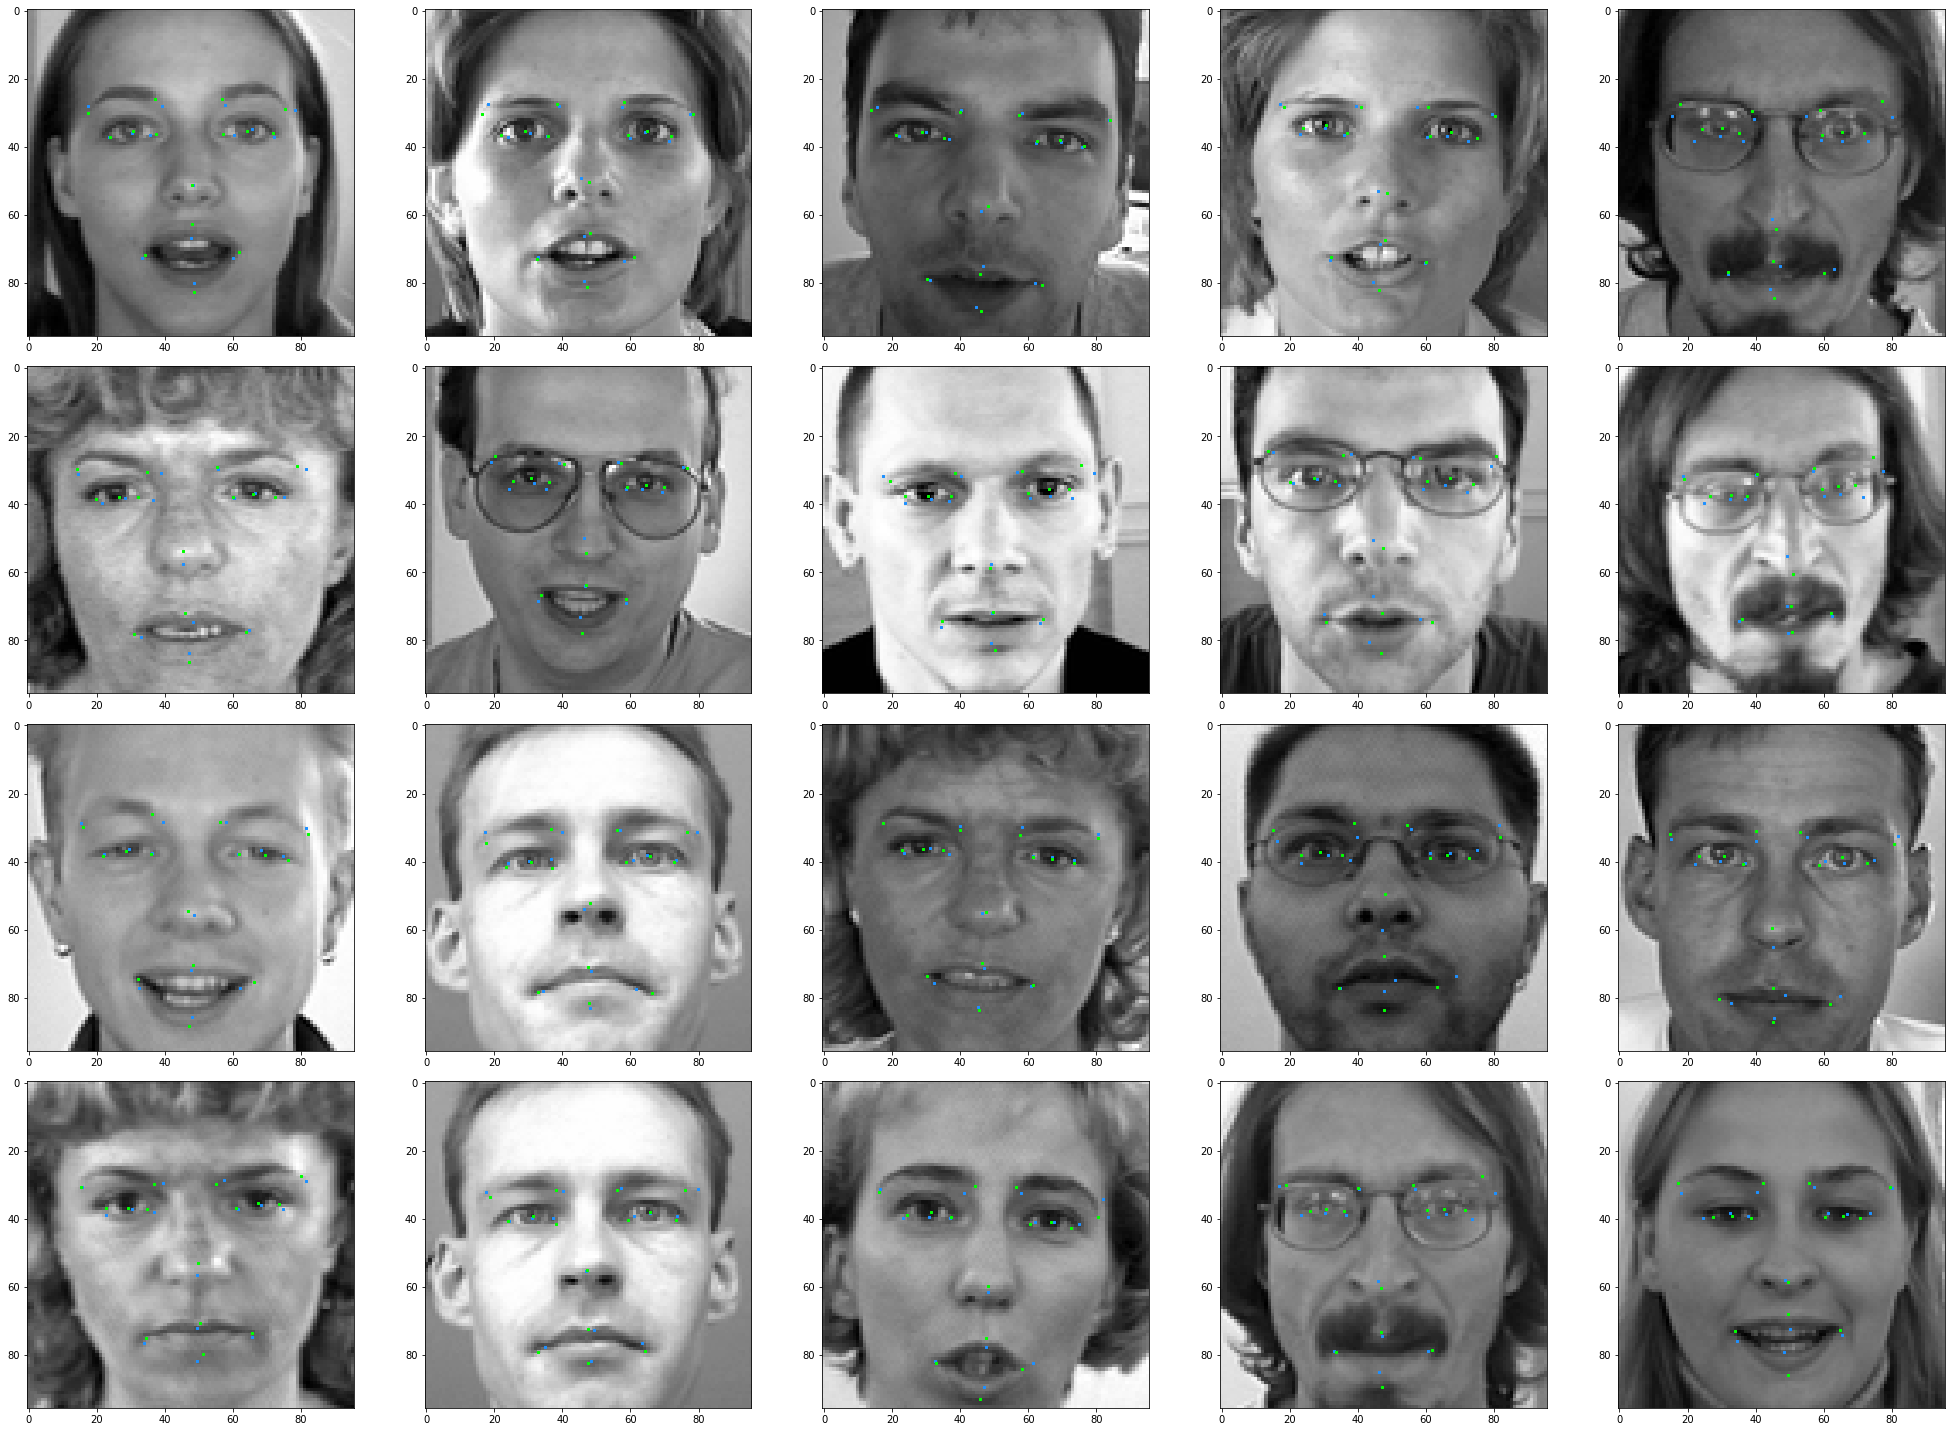



>>> Model V4 <<<

> Testing the model...


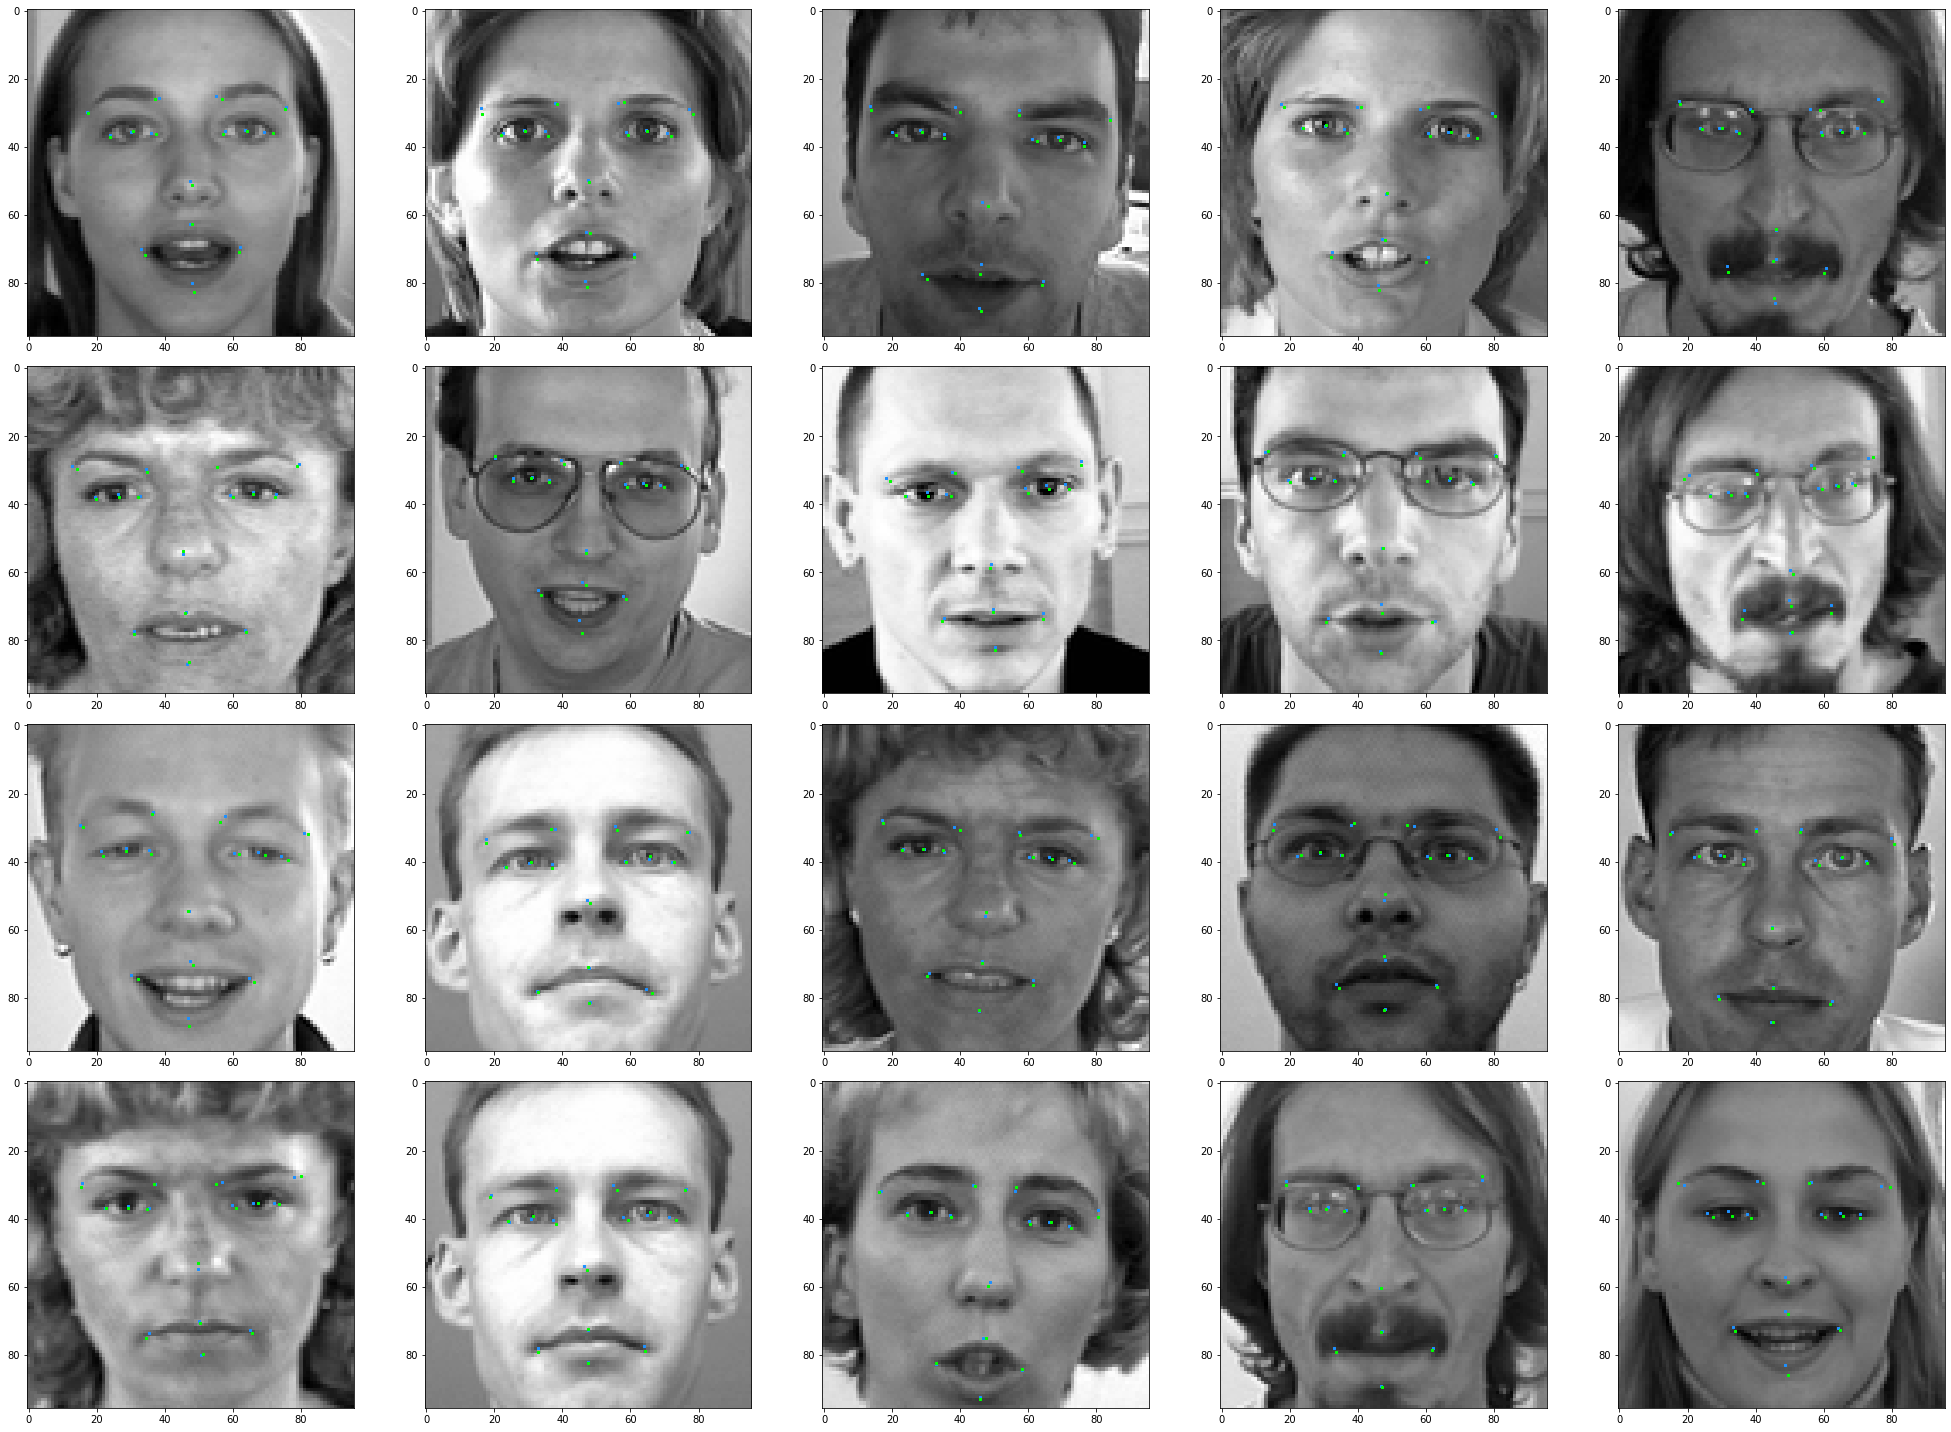

In [12]:
import matplotlib.pyplot as plt
from testing import testOnDataset

numberOfPoints, seed = 20, 30

print(">>> Model V1 <<<")
testOnDataset(modelV1, X_train[seed:seed+numberOfPoints], trueValues=y_train[seed:seed+numberOfPoints])
print("\n\n>>> Model V4 <<<")
testOnDataset(model, X_train[seed:seed+numberOfPoints], trueValues=y_train[seed:seed+numberOfPoints])

## On a webcam feed

In [ ]:
from util.imageUtil import drawMaxSquareInImage, drawPointsInImage, drawSquareInImage, grayImage, mapPointsFromSquareToImage, resizeImageToModelSize, violaJones, violaJonesGetFaceCascade
from util.videoUtil import selectPort, mirrorImage, prepareImageForPrediction
from google.colab.patches import cv2_imshow
import cv2 as cv

def testOnWebcamColab():
  """Loops through the video and shows the predictions."""
  print("- Starting the video loop...")
  print("- You can close the window by pressing 'q'.")
  print("- Press 's' to switch between the view modes and 'f' to toggle the frame around the face.")
  print("- Use '+' and '-' to change the size of the window.")
  print("- And press space to pause the feed.")

  # Window
  windowName = "Webcam-Feed"
  cv.namedWindow(windowName, cv.WINDOW_KEEPRATIO)
  frameCount = 0

  # Face recognition
  c, r, s = 0, 0, 0  # face location (column, row, sideLength)
  faceCascade = violaJonesGetFaceCascade()
  faceRecognitionFrames = 10  # every nth frame is used for face recognition
  faceRecognitionCountdown = 5  # number of frames to wait before old data is discarded
  countdown = faceRecognitionCountdown
  faceFound = False
  showFrame = True

  # Window size
  scale = 1  # scale of the window
  SCALE_STEP = 0.1  # step size of the window scale
  DEFAULT_PRED_WINDOW_SIZE = 384  # default size of the prediction window
  FEED_WIDTH, FEED_HEIGHT = int(cap.get(3)), int(cap.get(4))
  print(f"- Feed size: {FEED_WIDTH}x{FEED_HEIGHT}")
  DEFAULT_WINDOW_WIDTH, DEFAULT_WINDOW_HEIGHT = FEED_WIDTH, FEED_HEIGHT
  if min(FEED_WIDTH, FEED_HEIGHT) >= 1080:
      DEFAULT_WINDOW_WIDTH, DEFAULT_WINDOW_HEIGHT = FEED_WIDTH//2, FEED_HEIGHT//2
  cv.resizeWindow(windowName, DEFAULT_WINDOW_WIDTH, DEFAULT_WINDOW_HEIGHT)

  showPredImage = False  # show the 96x96 image that gets predicted on
  pause = False

  while(cap.isOpened()):
      if not pause:
          rv, frame = cap.read()  # BGR
          if not rv:
              break

          # mirroring if webcam input
          
          frame = mirrorImage(frame)

          im = grayImage(frame)

          if frameCount % faceRecognitionFrames == 0:
              faces = violaJones(im, faceCascade, min(FEED_WIDTH, FEED_HEIGHT))
              if len(faces) != 0:
                  faceFound = True
                  countdown = faceRecognitionCountdown
                  c, r, s1, s2 = faces[0]
                  s = max(s1, s2)
              else:
                  if (countdown == 0):
                      faceFound = False
                  else:
                      countdown -= 1

          if showPredImage:
              im = resizeImageToModelSize(im[r:r+s, c:c+s])
              if faceFound:
                  x, y = predictOnImage(model, im)
                  frame = drawPointsInImage(im[0], x, y)
              else:
                  frame = im[0]
          else:
              if faceFound:
                  im = resizeImageToModelSize(im[r:r+s, c:c+s])
                  x, y = predictOnImage(model, im)
                  x, y = mapPointsFromSquareToImage(x, y, c, r, s, FEED_WIDTH, FEED_HEIGHT)
                  frame = drawPointsInImage(frame, x, y)
                  if showFrame:
                      frame = drawSquareInImage(frame, c, r, s)

          cv.imshow(windowName, frame)

      # input handling
      key = cv.waitKey(1) & 0xFF
      if key == ord('s') or key == ord('+') or key == ord('-'):
          # change window
          if key == ord('+'):
              scale += SCALE_STEP
          elif key == ord('-'):
              scale -= SCALE_STEP
          else:
              showPredImage = not showPredImage

          if showPredImage:
              cv.resizeWindow(windowName, int(DEFAULT_PRED_WINDOW_SIZE * scale), int(DEFAULT_PRED_WINDOW_SIZE * scale))
          else:
              cv.resizeWindow(windowName, int(DEFAULT_WINDOW_WIDTH * scale), int(DEFAULT_WINDOW_HEIGHT * scale))
      elif key == ord('f'):
          showFrame = not showFrame
      elif key == ord('q'):
          # close the window
          break
      elif key == ord(' '):
          # pause the video
          pause = not pause

  cv.destroyAllWindows()


> Testing the model on the webcam feed...
- No ports found... Trying port 0.
- Starting the video loop...
- You can close the window by pressing 'q'.
- Press 's' to switch between the view modes and 'f' to toggle the frame around the face.
- Use '+' and '-' to change the size of the window.
- And press space to pause the feed.


In [2]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [40]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.padding = '4px';
      div.style.width = '100%';
      div.style.maxWidth = '800px';
      document.body.appendChild(div);

           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = video.videoWidth;
      captureCanvas.height = video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      stream = await createDom();
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return result;
    }
    ''')

  display(js)
  
def video_frame(bbox):
  return eval_js('stream_frame("{}")'.format(bbox))

In [42]:
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

print("To end the feed click on the video.")
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply)

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

To end the feed click on the video.


<IPython.core.display.Javascript object>